# COMP 541 - Deep Learning Course Fall 2020
## Project
### Berk Güler - berkguler20@ku.edu.tr

In [1]:
import Pkg; Pkg.add("IterTools"); Pkg.add("Knet"); Pkg.add("Plots"); Pkg.add("CUDA");
using Knet: Knet, dir, accuracy, progress, sgd, adam, load, save, gc, Param,param,param0, xavier, xavier_uniform, KnetArray, Data, minibatch, nll, relu, mat, training, dropout
using Statistics: mean
using Base.Iterators: flatten
using IterTools: ncycle, takenth
using Plots; default(fmt=:png,ls=:auto)
using DelimitedFiles, Statistics, Random
import CUDA
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})
dataset_directory_path = "../DATA"
dataset_directory = filter(x -> isdir(joinpath(dataset_directory_path, x)), readdir(dataset_directory_path))

   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `/scratch/users/berkguler20/.julia/environments/v1.5/Project.toml`
No Changes to `/scratch/users/berkguler20/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `/scratch/users/berkguler20/.julia/environments/v1.5/Project.toml`
No Changes to `/scratch/users/berkguler20/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `/scratch/users/berkguler20/.julia/environments/v1.5/Project.toml`
No Changes to `/scratch/users/berkguler20/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
No Changes to `/scratch/users/berkguler20/.julia/environments/v1.5/Project.toml`
No Changes to `/scratch/users/berkguler20/.julia/environments/v1.5/Manifest.toml`


7-element Array{String,1}:
 "doganay_experiment"
 "idil_experiment"
 "istenc_experiment"
 "omer_experiment"
 "ozan_experiment"
 "yahya_experiment"
 "zaid_experiment"

In [2]:
send_message(message) = run(`curl https://notify.run/zrqfxE0M1ypL5Dv4 -d $message`);

## Data Preprocessing

### Read and Assign all of the data

In [3]:
function split_and_convert(string_array,splitter)
    Rlength = length(string_array)
    Clength = length(split(string_array[1],splitter))
    Mdata = zeros(Float64,Rlength,Clength)
    for i in 1:Rlength
        row =  map(x->tryparse(Float64,x),split(string_array[i],splitter))
        Mdata[i,:] = row
    end
    return Mdata
end

split_and_convert (generic function with 1 method)

In [4]:
function data_selection(participant_directory_path)
    data_matrix = Array{Float32}(undef,0,10)
    participant_directory = readdir(participant_directory_path)
    for raw_txt_files in participant_directory
            txt_file_directory_path = joinpath(participant_directory_path, raw_txt_files)
            txt_file_directory = readdir(txt_file_directory_path)
            
            raw_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[4]))
            raw_data = split_and_convert(readlines(raw_data_file),",")
            close(raw_data_file)
            
            time_trimmer = 1:size(raw_data)[1]
            
            time_data_file = open(joinpath(txt_file_directory_path,txt_file_directory[9]))
            time_raw_data = split_and_convert(readlines(time_data_file)," ")
            time_data = time_raw_data[time_trimmer,2].-time_raw_data[1,2]
            
            # Time  Position Velocity F_fint F_int F_h m b a subtask 
            #  1        2       3        4     5    6  7 8 9    10     
            data_matrix = [data_matrix; time_data raw_data]
        end
    return data_matrix
end

data_selection (generic function with 1 method)

In [5]:
test_data = Array{Float32}(undef,0,10)
train_data = Array{Float32}(undef,0,10)

for participant_index in 1:length(dataset_directory)
    #Participants: 1.doganay 2.idil 3.istenc 4.omer 5.ozan 6.yahya 7.zaid
    participant_directory_path = joinpath(dataset_directory_path,dataset_directory[participant_index])
    participant_directory = readdir(participant_directory_path)
    if participant_index != 5
        train_data = [train_data; data_selection(participant_directory_path)]
    else
        test_data = [test_data; data_selection(participant_directory_path)]
    end
end

In [6]:
time_history = 25;
ARRAY = Array{Float32}
Knet.save("raw_data.jld2","train",train_data,"test", test_data)

Array{Float32,N} where N

#### One Hot Encoding

In [7]:
onehot(y) = (m = zeros(eltype(ARRAY),length(y),3); for i in 1:length(y);  m[i,y[i]]=1; end; ARRAY(m))

onehot (generic function with 1 method)

#### Normalizing

In [8]:
function normalize(x)
    return (x .- mean(x,dims=1)) ./ std(x,dims=1);
end

normalize (generic function with 1 method)

In [9]:
x_raw_train = [train_data[:,1] train_data[:,3] train_data[:,4] train_data[:,6]]; # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
x_raw_test  = [test_data[:,1] test_data[:,3] test_data[:,4] test_data[:,6]]; # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
y_train = convert(KnetArray{Int64},train_data[:,end]);
y_test  = convert(KnetArray{Int64},test_data[:,end]);

In [10]:
print(size(x_raw_train),size(x_raw_test),size(y_train),size(y_test))

(474619, 4)(86220, 4)(474619,)(86220,)

#### Sliding Time Window Approach

In [11]:
function slide_time(vector_raw, time_history__)
    X = Array{Float64}(undef,length(vector_raw),time_history__)
    buffer = ones(1,time_history__).*vector_raw[1]
    for i = 1:length(vector_raw)
        X[i,:] = buffer;
        buffer = [buffer[2:end]' vector_raw[i]];
    end
    return X
end

slide_time (generic function with 1 method)

In [12]:
function slide_time_window(x_raw, time_history_) # 1-) Time, 2-) Velocity, 3-) Interaction Force (filtered), 4-) Human Force
    buffer = ones(1,time_history_)
    time = x_raw[:,1]
    velocity = x_raw[:,2]
    ffint = x_raw[:,3]
    fh = x_raw[:,4]
    velocity_history = slide_time(velocity,time_history_);
    ffint_history = slide_time(ffint,time_history_);
    fh_history = slide_time(fh,time_history_);
    return [time velocity_history velocity ffint_history ffint fh_history fh]
end

slide_time_window (generic function with 1 method)

In [13]:
x_train = slide_time_window(x_raw_train,time_history);
x_test = slide_time_window(x_raw_test,time_history);

In [14]:
send_message("Data Reading is Done!")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    21    0     0  100    21      0     15  0:00:01  0:00:01 --:--:--    15

{}

100    23  100     2  100    21      1     14  0:00:02  0:00:01  0:00:01    15


Process(`curl https://notify.run/zrqfxE0M1ypL5Dv4 -d 'Data Reading is Done!'`, ProcessExited(0))

## Visualizing the DATA

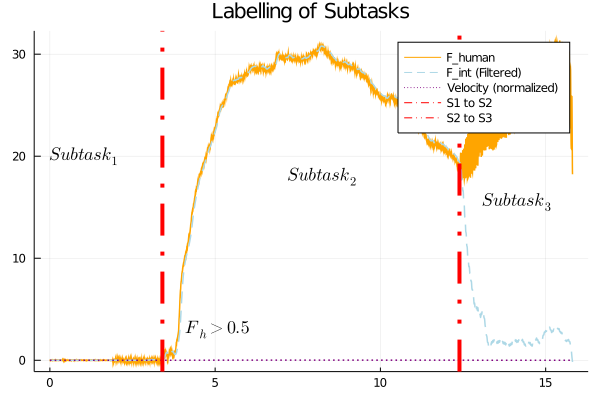

In [15]:
first_x_raw = x_raw_train[1:7907,:]
first_y_raw = train_data[1:7907,end];
sub1_sub2 = findall(x-> 3>x>1,first_y_raw)[1]
sub2_sub3 = findall(x-> x>2,first_y_raw)[1]
plot(first_x_raw[:,1],first_x_raw[:,4], title = "Labelling of Subtasks",  label = "F_human" ,lw = 1.5, fmt = :png, linecolor = "Orange")
plot!(first_x_raw[:,1],first_x_raw[:,3], label= "F_int (Filtered)", lw = 1.5, linecolor="LightBlue")
plot!(first_x_raw[:,1],x_train[1:7907,2], label= "Velocity (normalized)", lw = 1.5, linecolor="Purple")
plot!([first_x_raw[sub1_sub2,1]], seriestype="vline", lw = 4, linecolor = "Red", label ="S1 to S2")
plot!([first_x_raw[sub2_sub3,1]], seriestype="vline", lw = 4, linecolor = "Red", label ="S2 to S3")
annotate!(first_x_raw[sub1_sub2,1]+0.7, 3, text("\$F_h > 0.5 \$",Plots.font("Tahoma", 12),  :left))
annotate!(0, 20, text("\$Subtask_1 \$",Plots.font("Tahoma", 12),  :left))
annotate!(first_x_raw[sub1_sub2,1]+ 3.8, 18, text("\$Subtask_2 \$",Plots.font("Tahoma", 12),  :left))
annotate!(first_x_raw[sub2_sub3,1]+ 0.7, 15.5, text("\$Subtask_3 \$",Plots.font("Tahoma", 12),  :left))

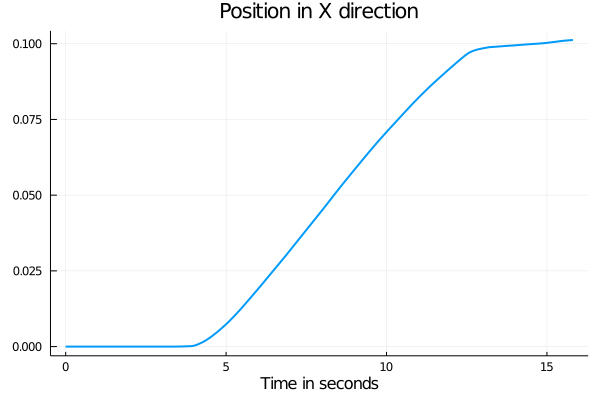

In [16]:
plot(train_data[1:7907,1],train_data[1:7907,2], title = "Position in X direction", label = false, lw = 2)
xlabel!("Time in seconds")

## MLP

In [17]:
dtrn2 = minibatch(x_train',y_train,64,xtype= array_type)
dtst2 = minibatch(x_test',y_test,64, xtype = array_type)

1347-element Data{Tuple{KnetArray{Float32,N} where N,KnetArray{Int64,N} where N}}

### Initializing the Parameters

In [18]:
function mytrain!(model, dtrn::Data, dtst::Data; lr_input=0.15, epoch::Int=100, optimizer)
    train_loss = Array{Float64,1}()
    test_loss = Array{Float64,1}()
    train_error = Array{Float64,1}()
    test_error = Array{Float64,1}()
    for x in takenth(progress(optimizer(model,lr=lr_input,ncycle(dtrn,epoch))),length(dtrn))
        push!(train_loss,model(dtrn))
        push!(test_loss,model(dtst))
        push!(train_error, 1-accuracy(model,data = dtrn))
        push!(test_error, 1-accuracy(model,data = dtst))
    end
    return 1:epoch, train_loss, test_loss, train_error, test_error
end

mytrain! (generic function with 1 method)

In [19]:
function train_n_show(model,dtrn,dtst,epoch_,learning_rate,optimizer_,Title)
    epoch = Array{Int64,1}()    
    trnloss = Array{Float64,1}()
    tstloss = Array{Float64,1}()
    trnerror = Array{Float64,1}()
    tsterror = Array{Float64,1}()
    epoch, trnloss, tstloss, trnerror, tsterror = mytrain!(model,dtrn,dtst,epoch = epoch_,lr_input = learning_rate ,optimizer=optimizer_);
    loss_graph = plot(epoch, trnloss, label="Training Loss" , xlabel = "epochs", ylabel = "loss", title=Title)
    plot!(epoch, tstloss, label="Test Loss")
    error_graph = plot(epoch, trnerror, label="Training Error" , xlabel = "epochs", ylabel = "error", title=Title)
    plot!(epoch, tsterror, label="Test Error")
    display(loss_graph)
    display(error_graph)
    print("Training Loss: ",round(minimum(trnloss),digits=4)," Test Loss: ", round(minimum(tstloss),digits=4))
    print("\nTraining Error: ",round(minimum(trnerror),digits=4)," Test Error: ", round(minimum(tsterror),digits=4))
end

train_n_show (generic function with 1 method)

In [20]:
struct Linear
    w
    b
    function Linear(inputsize::Int64, outputsize::Int64, scale::Float64=1e-3)
       new(Param(convert(array_type,randn(outputsize,inputsize)*scale)),Param(convert(array_type,zeros(outputsize,1))))
    end
end

(l::Linear)(x) = l.w*mat(x).+ l.b;
(l::Linear)(x,y) = nll(l(x),mat(y)) #It returns loss
(l::Linear)(d::Data) = mean(l(x,y) for (x,y) in d)  #Takes average of the losses

In [21]:
struct Dense
    w;
    b;
    f;
    p;
end

Dense(i::Int, o::Int, f=relu, pdrop=0) = Dense(param(o, i,init = xavier_uniform), param0(o), f, pdrop)

(d::Dense)(x) = d.f.(d.w * mat(dropout(x, d.p)).+ d.b )
(d::Dense)(x,y) = nll((d(x),mat(y)))
(d::Dense)(data::Data) = mean(d(x,y) for (x,y) in data)

In [22]:
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)
(c::Chain)(d::Data) = mean(c(x,y) for (x,y) in d)

┌ Warning: nll(scores, answers::KnetArray{Int64,1} is inefficient, nll(scores, answers::Array{<:Integer}) is better.
└ @ Knet.Ops20_gpu /kuacc/users/berkguler20/.julia/packages/Knet/OYNCT/src/ops20_gpu/loss.jl:8
┣▏                   ┫ [1.11%, 6569/593200, 00:22/33:07, 1008.18i/s] ] ┌ Warning: accuracy(scores, answers::KnetArray{Int64,1} is inefficient, nll(scores, answers::Array{<:Integer}) is better.
└ @ Knet.Ops20_gpu /kuacc/users/berkguler20/.julia/packages/Knet/OYNCT/src/ops20_gpu/loss.jl:13
┣████████████████████┫ [100.00%, 593200/593200, 14:21/14:21, 689.23i/s] 


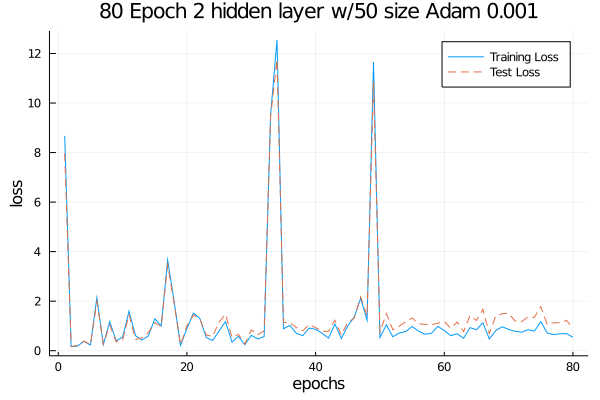

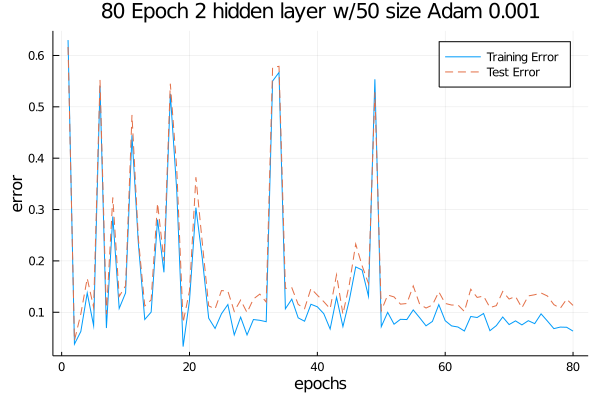

Training Loss: 0.1659 Test Loss: 0.1713
Training Error: 0.0331 Test Error: 0.0448

In [23]:
Random.seed!(10)
model = Chain(Linear(79,50),Linear(50,50), Linear(50,3))
train_n_show(model,dtrn2,dtst2,80,0.001,adam,"80 Epoch 2 hidden layer w/50 size Adam 0.001")

┣████████████████████┫ [100.00%, 593200/593200, 14:12/14:12, 696.19i/s] 


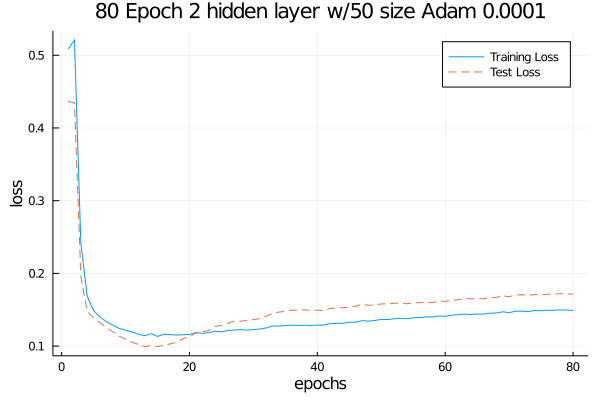

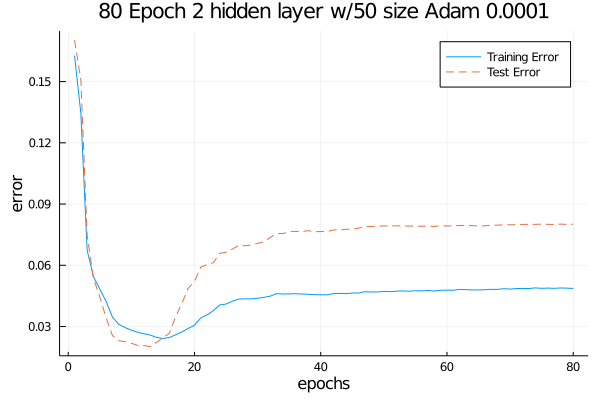

Training Loss: 0.1133 Test Loss: 0.0993
Training Error: 0.0242 Test Error: 0.0202

In [24]:
Random.seed!(10)
model = Chain(Linear(79,50),Linear(50,50), Linear(50,3))
train_n_show(model,dtrn2,dtst2,80,0.0001,adam,"80 Epoch 2 hidden layer w/50 size Adam 0.0001")

┣████████████████████┫ [100.00%, 1186400/1186400, 28:09/28:09, 702.44i/s] 


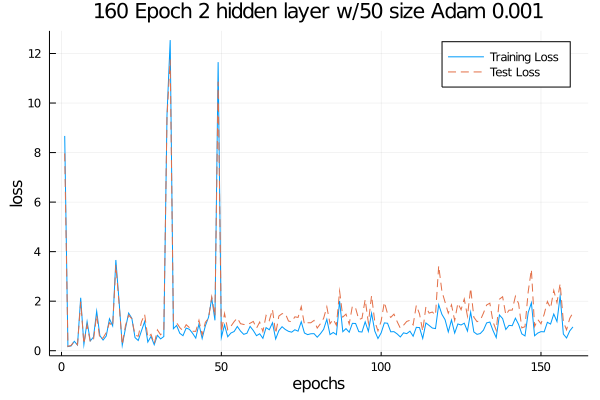

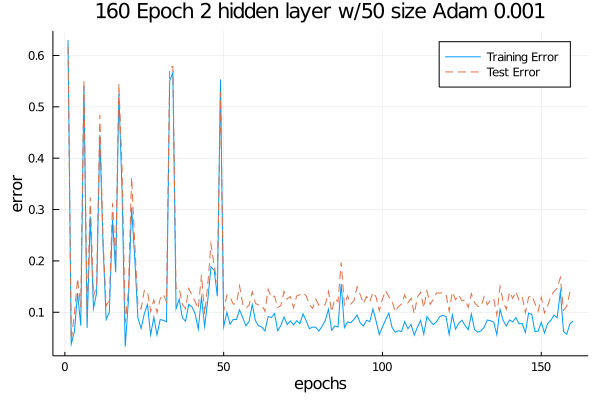

Training Loss: 0.1659 Test Loss: 0.1713
Training Error: 0.0331 Test Error: 0.0448

In [25]:
Random.seed!(10)
model = Chain(Linear(79,50),Linear(50,50), Linear(50,3))
train_n_show(model,dtrn2,dtst2,160,0.001,adam,"160 Epoch 2 hidden layer w/50 size Adam 0.001")

┣████████████████████┫ [100.00%, 1186400/1186400, 27:21/27:21, 723.13i/s] 


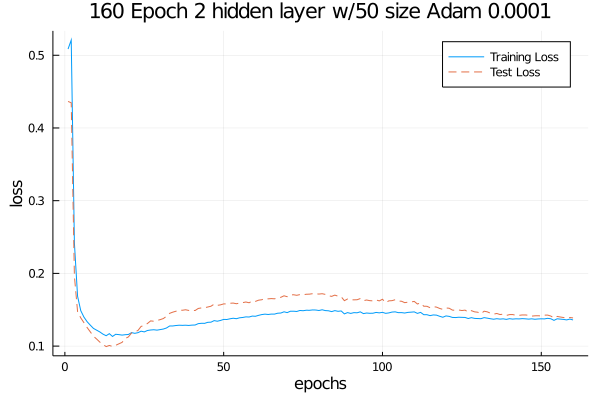

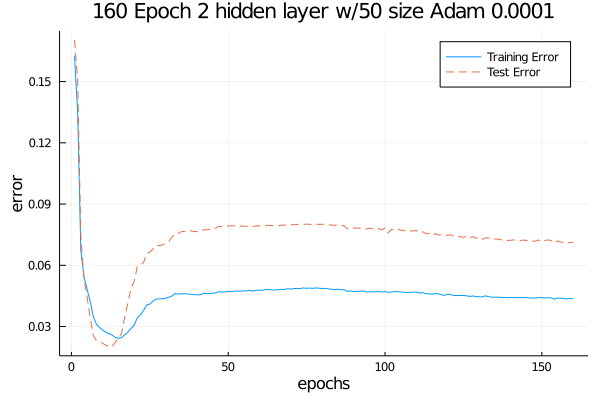

Training Loss: 0.1133 Test Loss: 0.0993
Training Error: 0.0242 Test Error: 0.0202

In [26]:
Random.seed!(10)
model = Chain(Linear(79,50),Linear(50,50), Linear(50,3))
train_n_show(model,dtrn2,dtst2,160,0.0001,adam,"160 Epoch 2 hidden layer w/50 size Adam 0.0001")

┣████████████████████┫ [100.00%, 593200/593200, 15:13/15:13, 649.69i/s] 


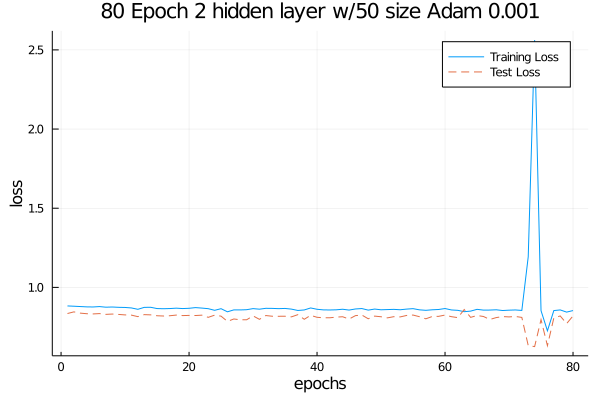

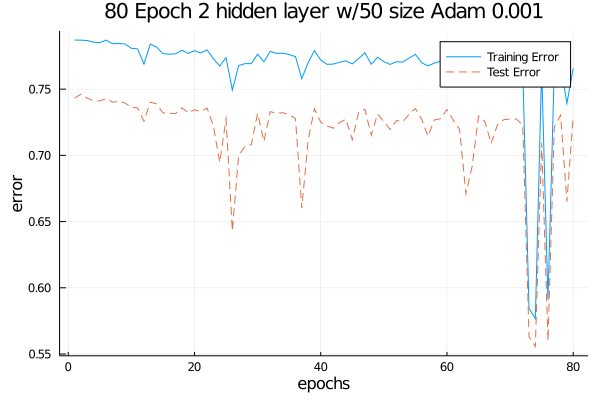

Training Loss: 0.7257 Test Loss: 0.626
Training Error: 0.5767 Test Error: 0.5556

In [27]:
Random.seed!(10)
model = Chain(Dense(79,50),Dense(50,50), Dense(50,3))
train_n_show(model,dtrn2,dtst2,80,0.001,adam,"80 Epoch 2 hidden layer w/50 size Adam 0.001")

┣████████████████████┫ [100.00%, 593200/593200, 15:01/15:01, 658.63i/s] 


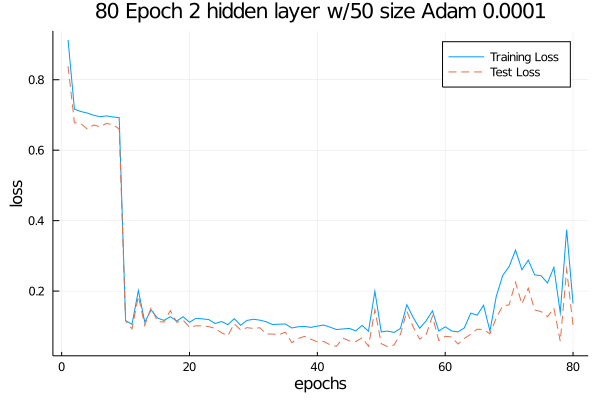

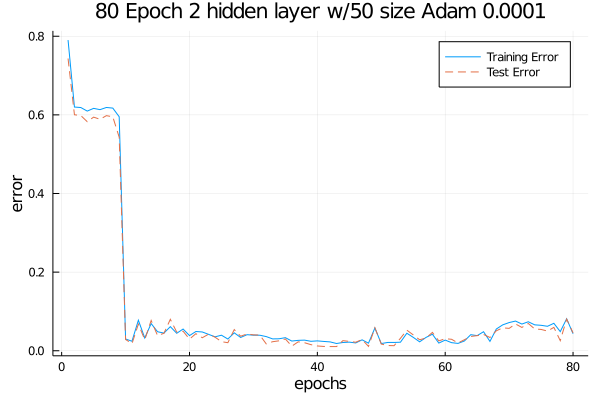

Training Loss: 0.0826 Test Loss: 0.0425
Training Error: 0.0183 Test Error: 0.0106

In [29]:
Random.seed!(10)
model = Chain(Dense(79,50,relu),Dense(50,50,identity), Dense(50,3))
train_n_show(model,dtrn2,dtst2,80,0.0001,adam,"80 Epoch 2 hidden layer w/50 size Adam 0.0001")

┣████████████████████┫ [100.00%, 593200/593200, 15:09/15:09, 652.46i/s] 


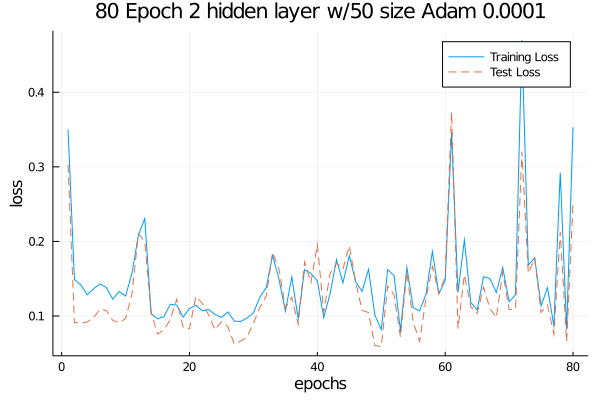

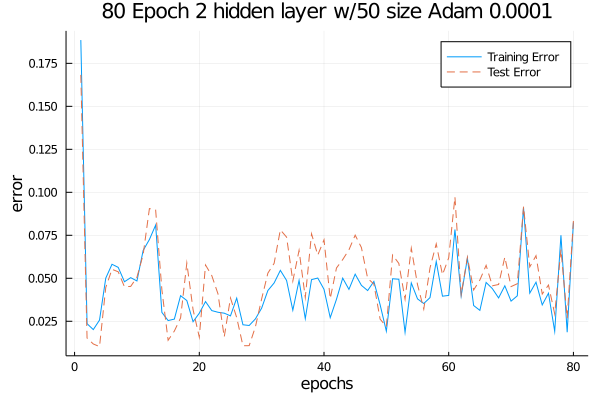

Training Loss: 0.0806 Test Loss: 0.059
Training Error: 0.0186 Test Error: 0.0103

In [30]:
Random.seed!(10)
model = Chain(Dense(79,50,relu),Dense(50,50,relu), Dense(50,3))
train_n_show(model,dtrn2,dtst2,80,0.0001,adam,"80 Epoch 2 hidden layer w/50 size Adam 0.0001")

┣████████████████████┫ [100.00%, 593200/593200, 15:10/15:10, 652.07i/s] 


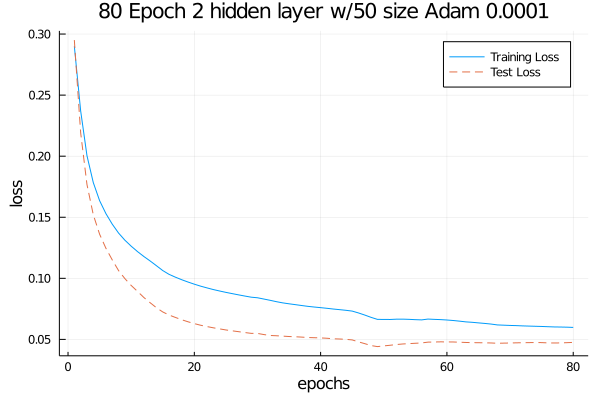

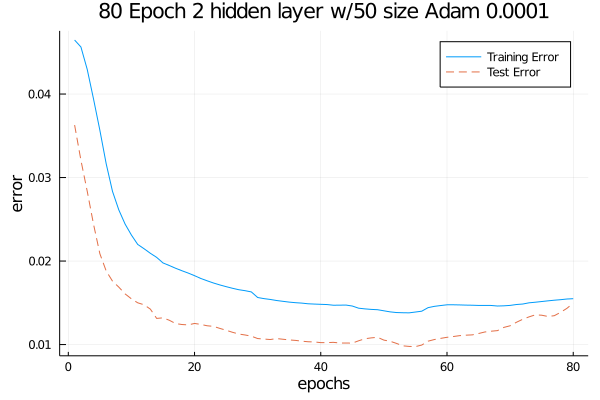

Training Loss: 0.0598 Test Loss: 0.0441
Training Error: 0.0138 Test Error: 0.0098

In [31]:
Random.seed!(10)
model = Chain(Dense(79,50,relu),Dense(50,50,relu), Dense(50,3))
train_n_show(model,dtrn2,dtst2,80,0.00001,adam,"80 Epoch 2 hidden layer w/50 size Adam 0.0001")